<a href="https://colab.research.google.com/github/thedataengineer/nvidia-bionemo-examples/blob/main/embed_ProtT5_disorder_structure_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SETH: Predicting nuances of a residue's disorder from protein embeddings
### Instructions
In the below block "Options and input specification", you need to specify the name of your fasta file containing the protein(s) for which you want a disorder prediction. Do this by replacing "myproteins.fasta". Then upload your file, for example by just using drag and drop after clicking on the folder icon in the sidebar.

Then click  `Runtime` -> `Run all`. The script will start running. Everything is finished when the last block has a green tickmark next to it.

After the run is finished, you find your disorder predictions at protT5/output/disorder_preds.fasta (find the folder protT5 by again clicking on the folder icon in the sidebar) and can download them by hovering over the file, clicking on the three points and selecting `Download`. The predictions will be given in CheZOD scores, which are a continuous measure of disorder, where values below 8 signify disorder and values above 8 signify order (see https://github.com/DagmarIlz/SETH).

&nbsp;

Optional:

You can look at the disorder over your protein sequence with the plot template available.

If you only input one protein: the protein will automatically be plotted.

If you input multiple proteins: the alphabetically first protein will automatically be plotted. You can adjust which protein is plotted by inserting the identifier of the protein used in disorder_preds.fasta in the third line of the block "Plot disorder over your protein sequence". The line should then read `MyProtein_to_plot="<identifier>"`. Then you need to  click on the round play button next to this block and the plot for your desired protein will be displayed.

In [ ]:
#@title Install requirements. { display-mode: "form" }
# Install requirements
!pip install torch transformers sentencepiece h5py

In [ ]:
#@title Set up working directories and download files/checkpoints. { display-mode: "form" }
# Create directory for storing model weights (2.3GB) and example sequences.
# Here we use the encoder-part of ProtT5-XL-U50 in half-precision (fp16) as
# it performed best in our benchmarks (also outperforming ProtBERT-BFD).
# Also download secondary structure prediction checkpoint and disorder prediction checkpoint to show annotation extraction from embeddings
!mkdir protT5 # root directory for storing checkpoints, results etc
!mkdir protT5/protT5_checkpoint # directory holding the ProtT5 checkpoint
!mkdir protT5/sec_struct_checkpoint # directory storing the supervised classifier's checkpoint
!mkdir protT5/disorder_checkpoint # directory storing the supervised disorder predictor's checkpoint
!mkdir protT5/output # directory for storing your embeddings & predictions
!wget -nc -P protT5/ https://rostlab.org/~deepppi/example_seqs.fasta
!wget -nc -P protT5/protT5_checkpoint https://rostlab.org/~deepppi/protT5_xl_u50_encOnly_fp16_checkpoint/pytorch_model.bin
!wget -nc -P protT5/protT5_checkpoint https://rostlab.org/~deepppi/protT5_xl_u50_encOnly_fp16_checkpoint/config.json
!wget -nc -P protT5/disorder_checkpoint https://rostlab.org/~deepppi/SETH_CNN.pt
# Huge kudos to the bio_embeddings team here! We will integrate the new encoder, half-prec ProtT5 checkpoint soon
!wget -nc -P protT5/sec_struct_checkpoint http://data.bioembeddings.com/public/embeddings/feature_models/t5/secstruct_checkpoint.pt

In [ ]:
#@title Options and input specification.
# In the following you can define your desired output. Current options:
# per_residue embeddings
# per_protein embeddings
# secondary structure predictions
# disorder predictions

# Replace this file with your own (multi-)FASTA
# Headers are expected to start with ">";
# seq_path = "./protT5/example_seqs.fasta" #this enables use of an example file
seq_path="./myproteins.fasta"

# whether to retrieve embeddings for each residue in a protein
# --> Lx1024 matrix per protein with L being the protein's length
# as a rule of thumb: 1k proteins require around 1GB RAM/disk
per_residue = True
per_residue_path = "./protT5/output/per_residue_embeddings.h5" # where to store the embeddings

# whether to retrieve per-protein embeddings
# --> only one 1024-d vector per protein, irrespective of its length
per_protein = False
per_protein_path = "./protT5/output/per_protein_embeddings.h5" # where to store the embeddings

# whether to retrieve secondary structure predictions
sec_struct = False
sec_struct_path = "./protT5/output/ss3_preds.fasta" # file for storing predictions

# whether to retrieve disorder predictions
disorder = True
disorder_path = "./protT5/output/disorder_preds.fasta" # file for storing predictions


# make sure that either per-residue or per-protein embeddings are stored
assert per_protein is True or per_residue is True or sec_struct is True or disorder is True, print(
    "Minimally, you need to active per_residue, per_protein, sec_struct. or disorder (or any combination)")


In [ ]:
#@title Import dependencies and check whether GPU is available. { display-mode: "form" }
from transformers import T5EncoderModel, T5Tokenizer
import torch
import h5py
import time
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using {}".format(device))
print("Used GPU: ", end='')
!nvidia-smi -L
print("Used CPU ", end='')
!lscpu |grep 'Model name'

Using cuda:0
Used GPU: GPU 0: Tesla T4 (UUID: GPU-61d2b478-3dc5-cb8f-69a2-582f749de6e2)
Used CPU Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
#@title Network architecture for secondary structure prediction. { display-mode: "form" }
# Convolutional neural network (two convolutional layers) to predict secondary structure
class ConvNet( torch.nn.Module ):
    def __init__( self ):
        super(ConvNet, self).__init__()
        # This is only called "elmo_feature_extractor" for historic reason
        # CNN weights are trained on ProtT5 embeddings
        self.elmo_feature_extractor = torch.nn.Sequential(
                        torch.nn.Conv2d( 1024, 32, kernel_size=(7,1), padding=(3,0) ), # 7x32
                        torch.nn.ReLU(),
                        torch.nn.Dropout( 0.25 ),
                        )
        n_final_in = 32
        self.dssp3_classifier = torch.nn.Sequential(
                        torch.nn.Conv2d( n_final_in, 3, kernel_size=(7,1), padding=(3,0)) # 7
                        )

        self.dssp8_classifier = torch.nn.Sequential(
                        torch.nn.Conv2d( n_final_in, 8, kernel_size=(7,1), padding=(3,0))
                        )
        self.diso_classifier = torch.nn.Sequential(
                        torch.nn.Conv2d( n_final_in, 2, kernel_size=(7,1), padding=(3,0))
                        )


    def forward( self, x):
        # IN: X = (B x L x F); OUT: (B x F x L, 1)
        x = x.permute(0,2,1).unsqueeze(dim=-1)
        x         = self.elmo_feature_extractor(x) # OUT: (B x 32 x L x 1)
        d3_Yhat   = self.dssp3_classifier( x ).squeeze(dim=-1).permute(0,2,1) # OUT: (B x L x 3)
        d8_Yhat   = self.dssp8_classifier( x ).squeeze(dim=-1).permute(0,2,1) # OUT: (B x L x 8)
        diso_Yhat = self.diso_classifier(  x ).squeeze(dim=-1).permute(0,2,1) # OUT: (B x L x 2)
        return d3_Yhat, d8_Yhat, diso_Yhat

In [ ]:
#@title Network architecture for disorder prediction. { display-mode: "form" }
# Convolutional neural network to predict disorder
class CNN( torch.nn.Module ):
    def __init__( self, n_classes=1, n_features=1024, pretrained_model=None ):
        super(CNN, self).__init__()
        # CNN weights are trained on ProtT5 embeddings
        self.n_classes = n_classes
        bottleneck_dim = 28
        self.classifier = torch.nn.Sequential(
                        #summarize information from 5 neighbouring amino acids (AAs)
                        #padding: dimension corresponding to AA number does not change
                        torch.nn.Conv2d( n_features, bottleneck_dim, kernel_size=(5,1), padding=(2,0) ),
                        torch.nn.Tanh(),
                        torch.nn.Conv2d( bottleneck_dim, self.n_classes, kernel_size=(5,1), padding=(2,0))
                        )

    def forward( self, x):
        '''
            L = protein length
            B = batch-size
            F = number of features (1024 for embeddings)
            N = number of output nodes (1 for disorder, since predict one continuous number)
        '''
        # IN: X = (B x L x F); OUT: (B x F x L, 1)
        x = x.permute(0,2,1).unsqueeze(dim=-1)
        Yhat = self.classifier(x) # OUT: Yhat_consurf = (B x N x L x 1)
        # IN: (B x N x L x 1); OUT: ( B x L x N )
        Yhat = Yhat.squeeze(dim=-1)
        return Yhat

In [ ]:
#@title Load the checkpoint for secondary structure or disorder prediction. { display-mode: "form" }
def load_model(model_want):
  if model_want=="disorder":
    model = CNN()
    checkpoint_dir="./protT5/disorder_checkpoint/SETH_CNN.pt"
  if model_want=="structure":
    checkpoint_dir="./protT5/sec_struct_checkpoint/secstruct_checkpoint.pt"
    model = ConvNet()
  state = torch.load( checkpoint_dir )
  model.load_state_dict(state['state_dict'])
  model = model.eval()
  model = model.half()
  model = model.to(device)
  if model_want=="disorder":
    print('Loaded disorder pred. model from epoch: {:.1f}'.format(state['epoch']))
  if model_want=="structure":
    print('Loaded sec. struct. model from epoch: {:.1f}'.format(state['epoch']))

  return model

In [ ]:
#@title Load ProtT5 in half-precision. { display-mode: "form" }
# Load ProtT5 in half-precision (more specifically: the encoder-part of ProtT5-XL-U50)
def get_T5_model():
    model = T5EncoderModel.from_pretrained("./protT5/protT5_checkpoint/", torch_dtype=torch.float16)
    model = model.to(device) # move model to GPU
    model = model.eval() # set model to evaluation model
    tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )

    return model, tokenizer

In [ ]:
#@title Read in file in fasta format. { display-mode: "form" }
def read_fasta( fasta_path, split_char="!", id_field=0):
    '''
        Reads in fasta file containing multiple sequences.
        Split_char and id_field allow to control identifier extraction from header.
        E.g.: set split_char="|" and id_field=1 for SwissProt/UniProt Headers.
        Returns dictionary holding multiple sequences or only single
        sequence, depending on input file.
    '''

    seqs = dict()
    with open( fasta_path, 'r' ) as fasta_f:
        for line in fasta_f:
            # get uniprot ID from header and create new entry
            if line.startswith('>'):
                uniprot_id = line.replace('>', '').strip().split(split_char)[id_field]
                # replace tokens that are mis-interpreted when loading h5
                uniprot_id = uniprot_id.replace("/","_").replace(".","_")
                seqs[ uniprot_id ] = ''
            else:
                # repl. all whie-space chars and join seqs spanning multiple lines, drop gaps and cast to upper-case
                seq= ''.join( line.split() ).upper().replace("-","")
                # repl. all non-standard AAs and map them to unknown/X
                seq = seq.replace('U','X').replace('Z','X').replace('O','X')
                seqs[ uniprot_id ] += seq
    example_id=next(iter(seqs))
    print("Read {} sequences.".format(len(seqs)))
    print("Example:\n{}\n{}".format(example_id,seqs[example_id]))

    return seqs

In [ ]:
#@title Generate embeddings and predictions. { display-mode: "form" }
# Generate embeddings via batch-processing
# per_residue indicates that embeddings for each residue in a protein should be returned.
# per_protein indicates that embeddings for a whole protein should be returned (average-pooling)
# max_residues gives the upper limit of residues within one batch
# max_seq_len gives the upper sequences length for applying batch-processing
# max_batch gives the upper number of sequences per batch
def get_embeddings( model, tokenizer, seqs, per_residue, per_protein, sec_struct, disorder,
                   max_residues=4000, max_seq_len=1000, max_batch=100 ):

    if sec_struct:
      sec_struct_model = load_model("structure")
    if disorder:
      disorder_model= load_model("disorder")

    results = {"residue_embs" : dict(),
               "protein_embs" : dict(),
               "sec_structs" : dict(),
               "disorder" : dict()
               }

    num_residue_embs=0


    # sort sequences according to length (reduces unnecessary padding --> speeds up embedding)
    seq_dict   = sorted( seqs.items(), key=lambda kv: len( seqs[kv[0]] ), reverse=True )
    start = time.time()
    batch = list()
    for seq_idx, (pdb_id, seq) in enumerate(seq_dict,1):
        seq = seq
        seq_len = len(seq)
        seq = ' '.join(list(seq))
        batch.append((pdb_id,seq,seq_len))

        # count residues in current batch and add the last sequence length to
        # avoid that batches with (n_res_batch > max_residues) get processed
        n_res_batch = sum([ s_len for  _, _, s_len in batch ]) + seq_len
        if len(batch) >= max_batch or n_res_batch>=max_residues or seq_idx==len(seq_dict) or seq_len>max_seq_len:
            pdb_ids, seqs, seq_lens = zip(*batch)
            batch = list()

            # add_special_tokens adds extra token at the end of each sequence
            token_encoding = tokenizer.batch_encode_plus(seqs, add_special_tokens=True, padding="longest")
            input_ids      = torch.tensor(token_encoding['input_ids']).to(device)
            attention_mask = torch.tensor(token_encoding['attention_mask']).to(device)

            try:
                with torch.no_grad():
                    # returns: ( batch-size x max_seq_len_in_minibatch x embedding_dim )
                    embedding_repr = model(input_ids, attention_mask=attention_mask)
            except RuntimeError:
                print("RuntimeError during embedding for {} (L={})".format(pdb_id, seq_len))
                continue

            if sec_struct: # in case you want to predict secondary structure from embeddings
              d3_Yhat, d8_Yhat, diso_Yhat = sec_struct_model(embedding_repr.last_hidden_state)


            for batch_idx, identifier in enumerate(pdb_ids): # for each protein in the current mini-batch
                s_len = seq_lens[batch_idx]
                # slice off padding --> batch-size x seq_len x embedding_dim
                emb = embedding_repr.last_hidden_state[batch_idx,:s_len]
                if sec_struct: # get classification results
                   results["sec_structs"][identifier] = torch.max( d3_Yhat[batch_idx,:s_len], dim=1 )[1].detach().cpu().numpy().squeeze()
                if disorder: #get disorder prediction if enabeled
                    d_Yhat=disorder_model(emb.detach().unsqueeze(dim=0))
                    results["disorder"][identifier]=d_Yhat.detach().cpu().numpy().squeeze()
                if per_residue: # store per-residue embeddings (Lx1024)
                    results["residue_embs"][ identifier ] = emb.detach().cpu().numpy().squeeze()
                    num_residue_embs=num_residue_embs+len(results["residue_embs"][ identifier ])
                if per_protein: # apply average-pooling to derive per-protein embeddings (1024-d)
                    protein_emb = emb.mean(dim=0)
                    results["protein_embs"][identifier] = protein_emb.detach().cpu().numpy().squeeze()


    passed_time=time.time()-start
    avg_time = passed_time/len(results["residue_embs"]) if per_residue else passed_time/len(results["protein_embs"])
    print('\n############# EMBEDDING STATS #############')
    print('Total number of per-residue embeddings: {}'.format(num_residue_embs))
    print('Total number of per-protein embeddings: {}'.format(len(results["protein_embs"])))
    print("Time for generating embeddings and predictions: {:.1f}[m] ({:.3f}[s/protein])".format(
        passed_time/60, avg_time ))
    print('\n############# END #############')
    return results

In [ ]:
#@title Write embeddings to disk. { display-mode: "form" }
def save_embeddings(emb_dict,out_path):
    with h5py.File(str(out_path), "w") as hf:
        for sequence_id, embedding in emb_dict.items():
            # noinspection PyUnboundLocalVariable
            hf.create_dataset(sequence_id, data=embedding)
    return None

In [ ]:
#@title Write predictions to disk. { display-mode: "form" }
def write_prediction_fasta(predictions, out_path, disor_or_struct):
  class_mapping = {0:"H",1:"E",2:"L"}
  if disor_or_struct=="disor":
    with open(out_path, 'w+') as out_f:
        out_f.write( '\n'.join(
            [ ">{}\n{}".format(
                seq_id, ', '.join( [str(j) for j in yhat] ))
            for seq_id, yhat in predictions.items()
            ]
              ) )
  if disor_or_struct=="struct":
    with open(out_path, 'w+') as out_f:
        out_f.write( '\n'.join(
            [ ">{}\n{}".format(
                seq_id, ''.join( [class_mapping[j] for j in yhat] ))
            for seq_id, yhat in predictions.items()
            ]
              ) )
  return None

In [ ]:
#@title Execution of the pipeline. { display-mode: "form" }
# Load the encoder part of ProtT5-XL-U50 in half-precision (recommended)
model, tokenizer = get_T5_model()
# Load example fasta.
seqs = read_fasta( seq_path )
# Compute embeddings and/or secondary structure predictions and/or disorder prediction
results = get_embeddings( model, tokenizer, seqs,
                         per_residue, per_protein, sec_struct, disorder)

# Store per-residue embeddings
if per_residue:
  save_embeddings(results["residue_embs"], per_residue_path)
if per_protein:
  save_embeddings(results["protein_embs"], per_protein_path)
if sec_struct:
  write_prediction_fasta(results["sec_structs"], sec_struct_path, disor_or_struct="struct")
if disorder:
  write_prediction_fasta(results["disorder"], disorder_path, disor_or_struct="disor")

In [ ]:
#@title Preparation for plotting. { display-mode: "form" }
if disorder==True:
  import matplotlib.pyplot as plt
  diso_pred = dict()
  with open("./protT5/output/disorder_preds.fasta", 'r') as fasta_f:
      for line in fasta_f:
          line=line.strip()
          # get identifier and create new entry
          if line.startswith('>'):
              identifier=line.replace(">","").replace("/","_").replace(".","_").split("!")[0]
              diso_pred[identifier] = ''
          else:
              diso_pred[identifier] = [float(i) for i in line.split(',') if i.strip()]

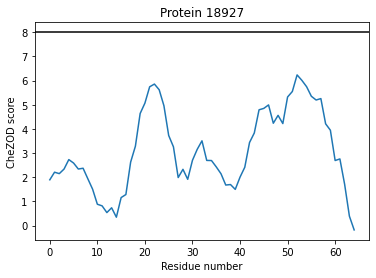

In [ ]:
#@title Plot disorder over your protein sequence.
if disorder==True:
  MyProtein_to_plot="" #here you can change which protein is plotted
  if MyProtein_to_plot=="":
    MyProtein_to_plot=list(diso_pred.keys())[0]
  plt.plot(range(0,len(diso_pred[MyProtein_to_plot])),diso_pred[MyProtein_to_plot])
  plt.xlabel('Residue number') # naming the x axis
  plt.ylabel('CheZOD score') # naming the y axis
  plt.title("Protein " + MyProtein_to_plot)
  plt.axhline(y=8, color='k', linestyle='-')